In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances
using Random
using Plots
using VectorizedRoutines;

In [2]:
#Hyperparameters
n = 10
N = 1000
σₐ = 0.001
bound = 1

k_range = 100
k_list = [i for i=1:100] #November 3
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
k_list_lite = [i for i in 1:k_range]
k_real = 8
k = k_real;

In [55]:
#Functions
function plot_data(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores)
    PyPlot.colorbar()
end

function plot_contour(data, scores, alpha=1.0)
    PyPlot.contour(data[:,1],data[:,2],c=scores)
end

function sample_data(x, y, n=N)
    perm = randperm(length(x[1,:]))[1:n]
    x_new1 = [x[1,perm[i]] for i=1:n]
    x_new2 = [x[2,perm[i]] for i=1:n]
    x_new = hcat(x_new1,x_new2)
    return x_new, y[perm]
end

mₖ(k) = k*4 + 1;

In [56]:
#Generative Interpolator Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    #if(typeof(x) == Float64)
        #x = [x]
    #end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, sigmoid),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

#Create a Random Network
@gen function generator(x::Array{Float64}, k=12)
    α = 0.09 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

In [28]:
print(size(x))

(2, 1000)

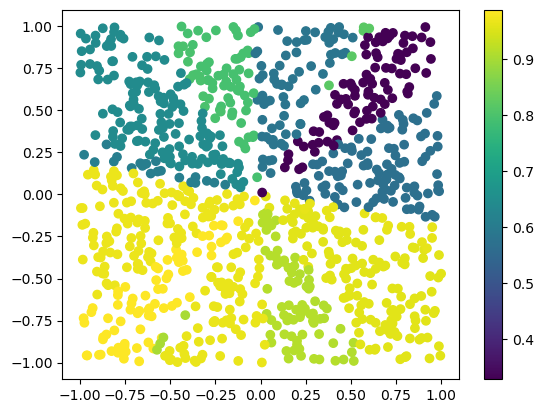

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbaab80e8d0>

In [57]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

y_real = Flux.σ.(G(x.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
#y_real = y_fake
plot_data(x_raw,y_real)

In [54]:
#Try Sampling the Data
x1_grid = range(0,stop=1,length=1000)
x2_grid = range(0,stop=1, length=1000)
data_grid = x1_grid .* x2_grid
#data_grid = reshape(data_grid, :, 2)
println(size(data_grid))
#println(data_grid)
#PyPlot.plot(data_grid[:,1],data_grid[:,2])
#plot_contour(x,y_samp)
#y_grid = Flux.σ.(G(data_grid.*100000,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])

(1000,)


In [139]:
#Classifier Network Tries to Learn the Generator Network

#@dist k_count() = categorical([1/length(k_list) for i=1:length(k_list)]) + 1

@gen function classifier(x::Array{Float64})
    α = 0.09 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.02 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [140]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

obs2 = choicemap()::ChoiceMap
obs2[:y] = y_real

#println(y_real)
#println(y_fake)

(trace1,) = generate(classifier, (x,), obs)
(trace2,) = generate(classifier, (x,), obs2)

score1 = exp(get_score(trace1)/length(y_real))
score2 = exp(get_score(trace2)/length(y_real))

println(score1)
println(score2)
println(score1/score2)

0.09170473133028761
1.4762184681775363e-7
621213.8196828114


In [141]:
#Register Observed Data
x_samp, y_samp = sample_data(x, y_real)
x_samp = transpose(x_samp)
size(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

8.957592416924989

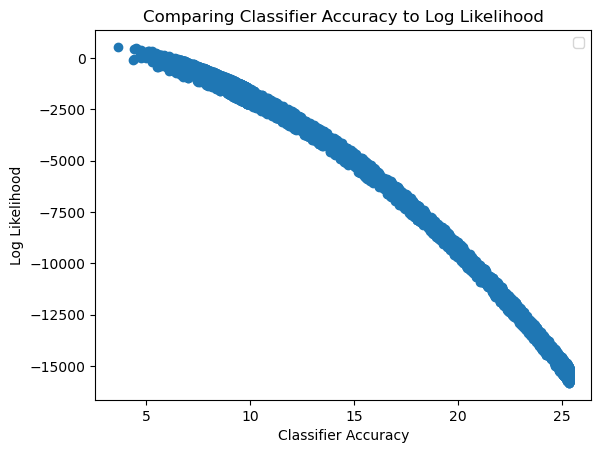

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7fbaaa2cb3d0>

In [142]:
#Plot of Log Likelihood Scores
x_samp, y_samp = sample_data(x, y_real)
#x_samp, y_samp = x, y_real
x_samp = transpose(x_samp)
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master;

scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    x_samp, y_samp = sample_data(x, y_real)
    #x_samp, y_samp = x, y_real
    x_samp = transpose(x_samp)
    obs_master = choicemap()::ChoiceMap
    obs_master[:y] = y_samp
    obs = obs_master;
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    #print(k)
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[:k]
    end
    #push!(best_ks,best_k)
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:6000
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

#for j=1:20
    #new_distances1 = [ks[i] == j ? distances[i] : -1 for i=1:length(distances)]
    #new_distances = filter(x -> x != -1, new_distances1)
    #new_scores1 = [ks[i] == j ? scores[i] : 100 for i=1:length(scores)]
    #new_scores = filter(x -> x < 100, new_scores1)
    #scatter(new_distances,new_scores,label=j)
#end
#plt.xlim(0,200)
#plt.ylim(-6000,0)
PyPlot.scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()
#println(best_trace[:k])
#println(best_dist)
#println(best_ks)

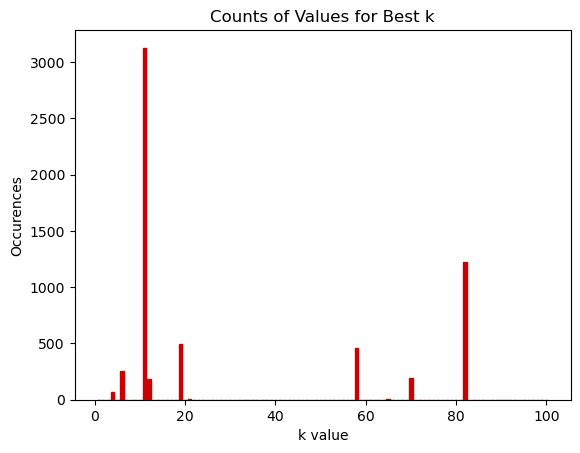

In [143]:
#print(best_ks)
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([best_ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for Best k")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [144]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = vcat(Wₕ,[uniform(-10,10) for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[uniform(-10,10) for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[uniform(-10,10) for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [164]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        #current_k = obs[:k]
        #println("w: $current_k")
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.01, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    #selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    #args = get_args(trace)
    #argdiffs = map((_) -> NoChange(), args)
    #(new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:iters
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.1, check=false, observations=obs)
        #accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("Old Trace Dist: $dist")
    
    Wₕ = new_trace[:Wₕ]
    Wₒ = new_trace[:Wₒ]
    bₕ = new_trace[:bₕ]
    bₒ = new_trace[:bₒ]
    k = new_trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    dist = euclidean(pred_y, y_real)
    #println("New Trace Dist: $dist")
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    score1 = exp(get_score(trace)/length(y_samp))
    score2 = exp(get_score(new_trace)/length(y_samp))
    score = score2/score1
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        #x_samp, y_samp = sample_data(x, y_real)
        #x_samp = transpose(x_samp)
        obs_master = choicemap()::ChoiceMap
        obs_master[:y] = y_samp
        obs = obs_master;
        if i%100 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            println("Epoch $i Across Acceptance Prob: $(sum(acc_a)/length(acc_a))")
            #print(obs[:k])
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 20000
#starting_trace = best_trace

#x_samp, y_samp = sample_data(x, y_real)
#x_samp = transpose(x_samp)
x_samp, y_samp = x, y_real
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_samp
obs = obs_master
(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 58
Epoch 100 Within Acceptance Prob: 0.9107142857142857
Epoch 100 Across Acceptance Prob: 1.0
Epoch 200 Within Acceptance Prob: 0.6283185840707964
Epoch 200 Across Acceptance Prob: 0.7558139534883721
Epoch 300 Within Acceptance Prob: 0.484472049689441
Epoch 300 Across Acceptance Prob: 0.5869565217391305
Epoch 400 Within Acceptance Prob: 0.5048076923076923
Epoch 400 Across Acceptance Prob: 0.6649214659685864
Epoch 500 Within Acceptance Prob: 0.4307692307692308
Epoch 500 Across Acceptance Prob: 0.5815899581589958


InterruptException: InterruptException:

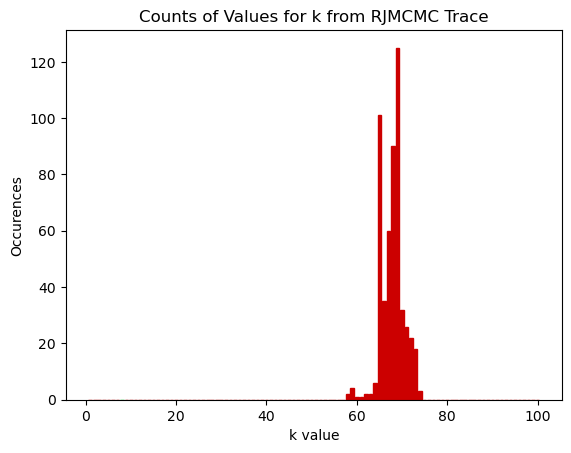

In [165]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=PyPlot.bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[k_real].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

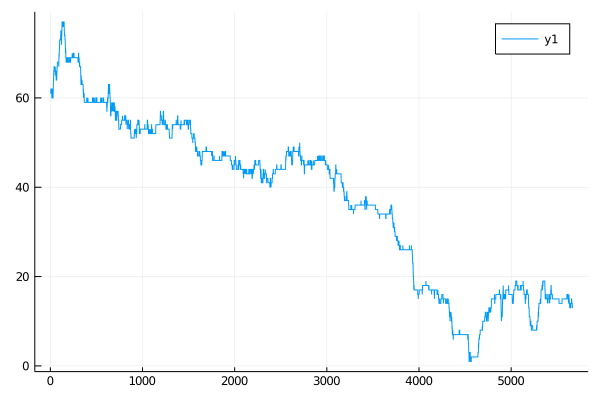

In [157]:
Plots.plot(ks)

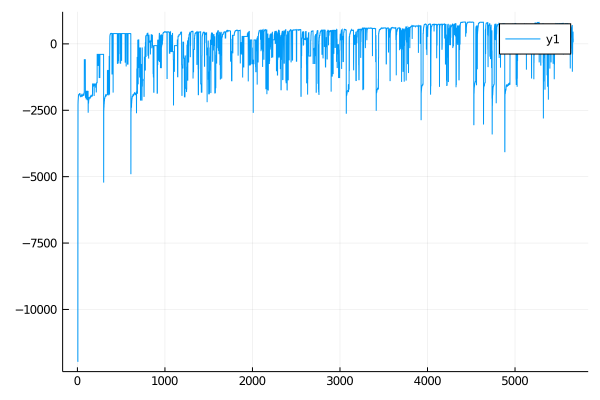

In [158]:
scores = [get_score(traces[i]) for i=1:length(traces)]
Plots.plot(scores[1:length(scores)])
#print(length(scores))

In [ ]:
#Try Dynamic Plotting

anim = @animate for i ∈ 1:runs
    colors = ["lightblue" for i=1:k_range]
    colors[k_real] = "lightgreen"
    colors[ks[i]] = "red"
    Plots.histogram(
        ks[1:i], 
        bins=1:k_range+1,
        fillcolor=colors),
        title="Estimated Marginal Posterior Distribution of k",
        xlabel="k: Number of Hidden Nodes",
        ylabel="Occurences",
        legend=false
    )
end

gif(anim, "anim_fps20000.gif", fps = 20000)

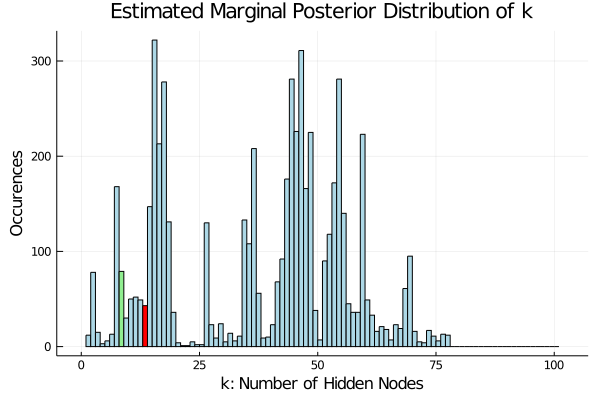

In [159]:
colors = ["lightblue" for i=1:k_range]
colors[k_real] = "lightgreen"
colors[ks[length(ks)]] = "red"
p4 = Plots.histogram(
    ks, 
    bins=1:k_range+1, 
    fillcolor=colors, 
    title="Estimated Marginal Posterior Distribution of k",
    xlabel="k: Number of Hidden Nodes",
    ylabel="Occurences",
    legend=false
)


In [203]:
#Fixed Network Time: Figure out which k is actually best

#Return a Flexible Network
function model(k::Int) 
    return Chain(
        Dense(2, k, σ),
        Dense(k, 1, σ))
end;

num_params(model) = sum(length, Flux.params(model)) 

round4(x) = round(x, digits=4)

penalty(m) = sum(abs2, Flux.params(m)[1]) + sum(abs2, Flux.params(m)[2]) + sum(abs2, Flux.params(m)[3])
lossa(y_hat, y, m) = Flux.Losses.mse(y_hat, y) + penalty(m)

function getdata(x,y)
    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(x)

    # One-hot-encode the labels
    ytrain = Flux.flatten(y_real)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=N, shuffle=true)

    return train_data
end

y_hat = (model(6))(x)
test_model = model(6)
#println(Flux.params(test_model)[1])
#println(Flux.params(test_model)[2])
#println(Flux.params(test_model)[3])
#println(Flux.params(test_model)[4])
print(lossa(y_hat, y_real, model(6)))

function eval_loss_accuracy(x, y, net)
    return loss(net(x), y)
end

function train(x,y,m,epochs)
    losses = []
    
    # Load Data
    train_data = getdata(x,y)

    # Construct model
    loss(x,y) = Flux.Losses.mse(m(x), y) + penalty(m)
    
    ## Training
    opt = Flux.Optimise.ADAM()

    for i=1:epochs
        Flux.train!(loss, Flux.params(m), train_data, opt)
        loss1 = eval_loss_accuracy(x,y,m)
        push!(losses,loss1)
        #println(Flux.params(m))
    end
    return m, losses
end

6.216964084151914

train (generic function with 1 method)

In [217]:
training_runs = 1700
a,b,c,d,e = 7, 7, 7, 7, 7

m1 = model(a)
m1_trained, losses1 = train(x, y_real, m1, training_runs);

In [218]:
m2 = model(b)
m2_trained, losses2 = train(x, y_real, m2, training_runs);

In [219]:
m3 = model(c)
m3_trained, losses3 = train(x, y_real, m3, training_runs);

In [220]:
m4 = model(d)
m4_trained, losses4 = train(x, y_real, m4, training_runs);

In [221]:
m5 = model(e)
m5_trained, losses5 = train(x, y_real, m5, training_runs);

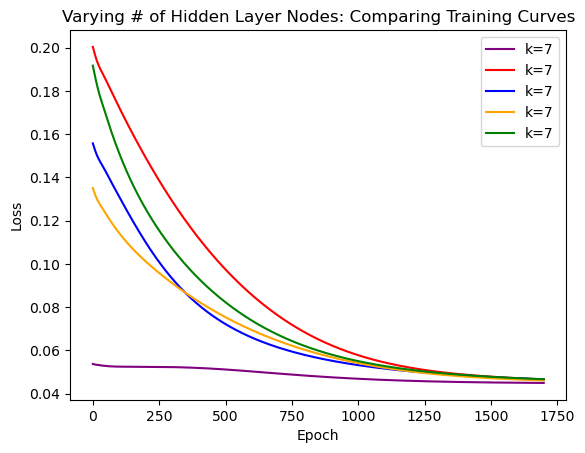

PyObject <matplotlib.legend.Legend object at 0x7fbaab632350>

In [222]:
PyPlot.plot(losses1, color="purple", label="k=$a")
PyPlot.plot(losses2, color="red", label="k=$b")
PyPlot.plot(losses3, color="blue", label="k=$c")
PyPlot.plot(losses4, color="orange", label="k=$d")
PyPlot.plot(losses5, color="green", label="k=$e")
PyPlot.title("Varying # of Hidden Layer Nodes: Comparing Training Curves")
PyPlot.xlabel("Epoch")
PyPlot.ylabel("Loss")
PyPlot.legend()

7


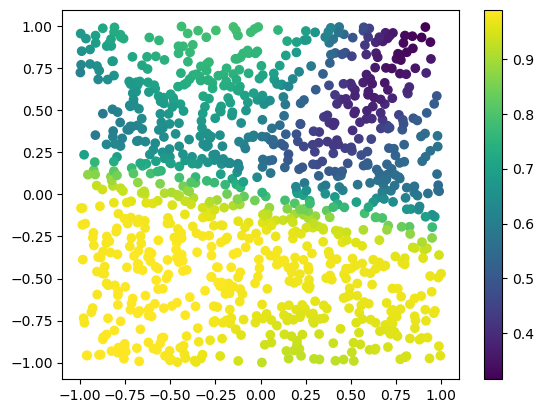

2.181727677962822


In [163]:
best_i = 1
for i=1:length(traces)
    test_trace = traces[i]
    test_score = get_score(test_trace)
    if test_score > get_score(traces[best_i])
        best_i = i
        #print(test_score)
    end
    #println("Epoch $i Score: $test_score")
end

test_trace = traces[best_i]
tWₕ = test_trace[:Wₕ]
tWₒ = test_trace[:Wₒ]
tbₕ = test_trace[:bₕ]
tbₒ = test_trace[:bₒ]
tk = test_trace[:k]
println(tk)

y_test = Flux.σ.(G(x,tWₕ,tbₕ,tWₒ,tbₒ,tk)[1,:])
plot_data(x_raw,y_test)
println(euclidean(y_test, y_real))

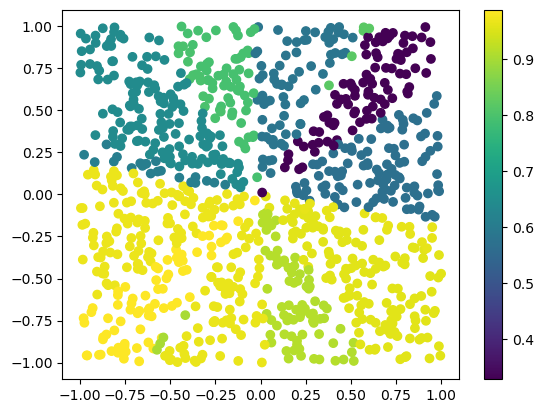

PyObject <matplotlib.colorbar.Colorbar object at 0x7fbaaa49f190>

In [132]:
plot_data(x_raw,y_real)